In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.integrate import solve_ivp
from network import network
from training import trainNetwork
from dynamics import *
from generateData import assembleData

In [2]:
system="Robert"

In [3]:
d = 3 #dimension of the phase space

if system=="SIR":
    t_min = 0.
    t_max = 1e4
    y0 = np.array([0.3,0.5,0.2])
else:
    t_min = 0. #initial time
    t_max = 1e6 #final time
    y0 = np.array([1.,0.,0])

In [4]:
output = solve_ivp(ode,[t_min,t_max], y0, method = 'BDF', atol=1e-4, rtol=1e-4, args=(system,))
sol,time = output.y,output.t

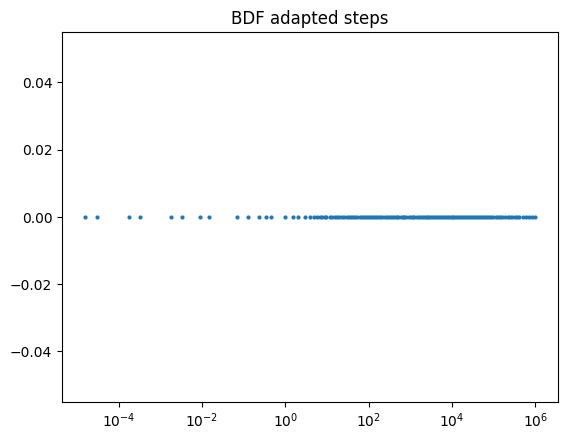

In [5]:
plt.semilogx(time,time*0,'o',markersize=2)
plt.title("BDF adapted steps")
plt.show();

In [6]:
M = len(time)
N = min(5,M)

which_idxs = lambda n, m: np.rint(
      np.linspace(1,m, min(n,m))-1).astype(int) 

coarse_time = time[which_idxs(N+1,M)]
initial_guesses = sol[:,which_idxs(N+1,M)]
dts = np.diff(coarse_time)

$$
\mathcal{D} = \{(t_j,\Phi^{t_j}(x_i))\}_{i=1,...,N}^{j=1,...,M},\,\,\{x_1,...,x_N\}\subset\Omega\subset\mathbb{R}^3,\,\,t_j\in [0,\Delta t]
$$

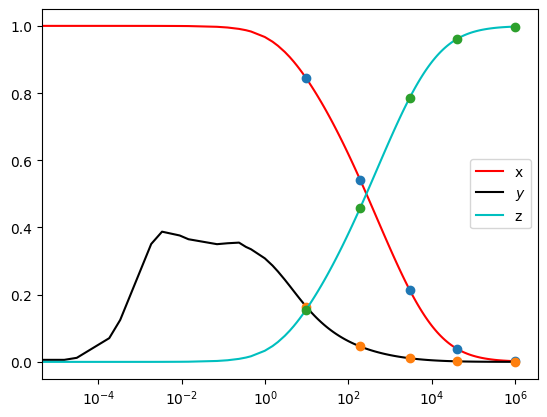

In [7]:
fact = 1e4 * (system=="Robert") + 1. * (system=="SIR")

plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'o')
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'o')
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'o')
plt.legend()
plt.show();

In [8]:
networks = []

lr = 1e-2
wd = 1e-5
epochs = 10000
tol = 1e-6

def pararealCorrection(fine_uprev,coarse_uprev,coarse_ucurrent):
    return fine_uprev + coarse_ucurrent - coarse_uprev

def computeError(coarse_uprev,coarse_current):
    return np.linalg.norm(coarse_current - coarse_uprev,axis=0,ord=2)

is_converged = False
sol_k = np.zeros((N+1,d)) #current
sol_km = np.zeros((N+1,d)) #previous

sol_k[0] = initial_guesses[:,0]
#sol_km[0] = initial_guesses[:,0]

k = 0

data = {f"n={i}": None for i in range(N)}

first = 0

while is_converged==False and k<5:
    
    print(f"\n\n We are at iterate {k} of the parareal training procedure \n\n")    
    
    if k==0:
        for n in range(N):
            dt = coarse_time[n+1]-coarse_time[n]
            print(f"\n\n The considered time interval now is [{coarse_time[n]},{coarse_time[n+1]}] \n\n")
            data[f"n={n}"] = assembleData(coarse_time[n],coarse_time[n+1],sol_k[n],system)
            networks.append(network(coarse_time[n],coarse_time[n+1],d))
            tt = torch.tensor([[coarse_time[n]-coarse_time[n-1]]],dtype=torch.float32)
            loss_is_large = trainNetwork(coarse_time[n],coarse_time[n+1],networks[n],d,lr,wd,epochs,system,data[f"n={n}"],is_pinn=False,is_reg=True)
            yy = torch.from_numpy(sol_k[n].astype(np.float32)).unsqueeze(0)
            val = networks[n](tt,yy).detach().cpu().numpy()[0]
            sol_k[n+1] = val
            sol_km[n+1] = val
            
            '''if loss_is_large==False and first==n:
                first = n+1'''
    else:
        lr = lr / 2
        for n in np.arange(first,N):
            
            print(f"\n\n The considered time interval now is [{coarse_time[n]},{coarse_time[n+1]}] \n\n")
            #We use the previously trained network as an initial guess
            dt = coarse_time[n+1]-coarse_time[n]
            #This is to train the coarse predictor at the current update of the initial condition
            data_temp = assembleData(coarse_time[n],coarse_time[n+1],sol_k[n],system)
            data[f"n={n}"] = data_temp #[np.concatenate((x, y), axis=0) for x, y in zip(data[f"n={n}"], data_temp)]
                
            #networks[n] = network(coarse_time[n],coarse_time[n+1],d) #if we do not want to use the previously trained network
                
            #The data below should already be included in the dataset since u_prev was u_current at the previous iterate
            '''#This is to train the coarse predictor at the previous update of the initial condition
            data_temp_previous = assembleData(coarse_time[n],coarse_time[n+1],initials_km[n],system)
            data[f"n={n}"] = [np.concatenate((x, y), axis=0) for x, y in zip(data[f"n={n}"], data_temp_previous)]'''
                
            loss_is_large = trainNetwork(coarse_time[n],coarse_time[n+1],networks[n],d,lr,wd,epochs,system,data[f"n={n}"],is_pinn=False,is_reg=True)
            
            tt = torch.tensor([[dt]],dtype=torch.float32)
            #u_previous = torch.from_numpy(sol_km[n].astype(np.float32)).unsqueeze(0)
            #u_current = torch.from_numpy(sol_k[n].astype(np.float32)).unsqueeze(0)
            #coarse_pred_previous = networks[n](tt,u_previous).detach().cpu().numpy()[0]
            #coarse_pred_current = networks[n](tt,u_current).detach().cpu().numpy()[0]
            
            yy = torch.from_numpy(sol_k[n].astype(np.float32)).unsqueeze(0)
            
            #sol_km[n+1] = sol_k[n+1]
            sol_k[n+1] = networks[n](tt,yy).detach().cpu().numpy()[0]#data[f"n={n}"][1][-1]#pararealCorrection(data[f"n={n}"][1][-1],coarse_pred_previous,coarse_pred_current)
            #error = np.linalg.norm(sol_km[n+1]-sol_k[n+1],ord=2)
            #print(f"\n\n Error is {error} \n\n")
            #is_converged = (error<tol)*is_converged
            #print(f"\n\n Is it converged? {is_converged} \n\n")
   
            '''if loss_is_large==False and first==n:
                first = n+1'''
            
    k+=1



 We are at iterate 0 of the parareal training procedure 




 The considered time interval now is [0.0,9.649594679592978] 


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.969e-01 ...  9.453e+00  9.650e+00]
        y: [[ 1.000e+00  9.924e-01 ...  8.458e-01  8.442e-01]
            [ 0.000e+00  3.514e-05 ...  1.659e-05  1.646e-05]
            [ 0.000e+00  7.545e-03 ...  1.542e-01  1.558e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 144
     njev: 4
      nlu: 19
Epoch 50, Loss 0.0004922464722767472
Epoch 100, Loss 0.0003266033891122788
Epoch 150, Loss 0.00024416379164904356
Epoch 200, Loss 0.00016827044601086527
Epoch 250, Loss 0.00012391824566293508
Epoch 300, Loss 0.00010042966459877789
Epoch 350, Loss 0.00018976948922500014
Epoch 400, Loss 0.00014659239968750626
Epoch 450, Loss 0.00019121808873023838
Epoch 500, Loss 9.99295589281246e-05
Epoch 550, Loss 0.00018706235277932137
Ep

- Iterate 0 : No data and the network should provide the initial guesses for the coarse grid (PINN)
- Iterate 1, 2,... : Combine the two losses where the regression part is based on the evaluations of
the fine integrator at the previous iterates.

In [9]:
coarse_preds = sol_k.T

In [10]:
output = solve_ivp(ode,[t_min,t_max], y0, method = 'BDF', atol=1e-10, rtol=1e-10, args=(system,))
sol,time = output.y,output.t

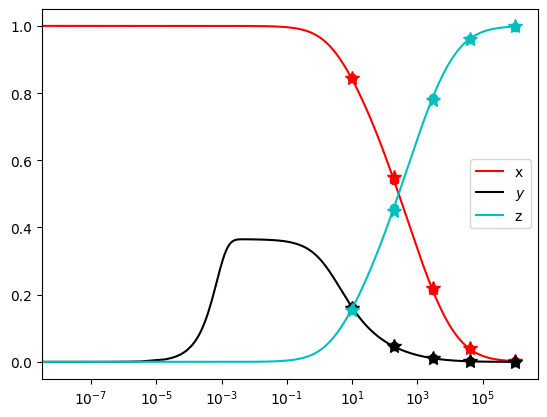

In [11]:
plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'ro')
plt.semilogx(coarse_time,coarse_preds[0],'r*',markersize=10)
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'ko')
plt.semilogx(coarse_time,coarse_preds[1]*fact,'k*',markersize=10)
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'co')
plt.semilogx(coarse_time,coarse_preds[2],'c*',markersize=10)
plt.legend()
plt.show();